# Imports and parameters

In [1]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import copy
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt

from PerseusGammaCalibration import perseus_model_library
from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
# Data
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'

# Map parameters
FWHM_planck = 10.0*u.arcmin
map_fov = 6*u.deg
map_reso = 5*u.arcmin
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))

# Analysis
Nmc = 500
mask_source = True
NFWHMmask = 3
src1 = SkyCoord("3h19m48.16s +41d30m42s", frame='icrs')              # NGC1275
src2 = SkyCoord(48.25948051*u.deg, +41.35073379*u.deg, frame='icrs') # as the peak of the map
yprof_reso = 5.0*u.arcmin

# Define the cluster model

In [3]:
cluster = perseus_model_library.default_model()
cluster.set_pressure_gas_gNFW_param('P13UPP')
cluster.map_fov = map_fov
cluster.map_reso = map_reso

# Extract the Planck map

### Raw map

In [4]:
ymap_data, header = map_tools.roi_extract_healpix(ymap_file, cluster.coord.ra.value, cluster.coord.dec.value, 
                                                  cluster.map_reso.to_value('deg'), 
                                                  [cluster.map_fov[0].to_value('deg'), cluster.map_fov[1].to_value('deg')],
                                                  visu=False)
#cluster.map_header = header

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


### Error map and mask

Text(0.5, 1.0, 'Source mask')

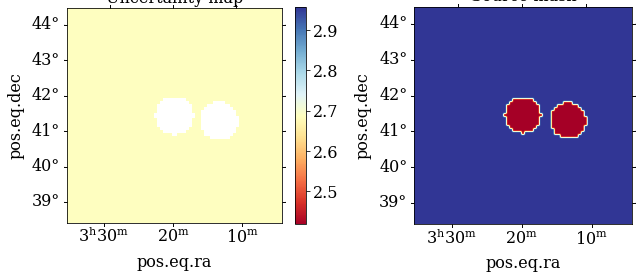

In [5]:
# First guess for the error
ymap_err = ymap_data*0 + np.std(ymap_data)

# Flag signal
for i in [1,2,3,4,5,6]: 
    ymap_err = ymap_data*0 + np.std(ymap_data[np.abs(ymap_data/ymap_err) < 3])
mask = ymap_err*0+1
    
# Mask central source
ramap, decmap = map_tools.get_radec_map(header)
# Central
if mask_source:
    distance = map_tools.greatcircle(ramap, decmap, src1.ra.to_value('deg'), src1.dec.to_value('deg'))
    ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
    mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0
    
# Secondary
distance = map_tools.greatcircle(ramap, decmap, src2.ra.to_value('deg'), src2.dec.to_value('deg'))
ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0

# Show the map
fig = plt.figure(0, figsize=(10, 4))
ax = plt.subplot(121, projection=WCS(header))
plt.imshow(1e6*ymap_err, origin='lower', cmap='RdYlBu')
plt.colorbar()
plt.title('Uncertainty map')

ax = plt.subplot(122, projection=WCS(header))
plt.imshow(mask, origin='lower', cmap='RdYlBu')
plt.title('Source mask')

# P13UPP - data comparison

In [6]:
ctmp = copy.deepcopy(cluster)
ctmp.set_pressure_gas_gNFW_param('P13UPP')
ymap_p13upp = ctmp.get_sz_map(Compton_only=True)
ymap_p13upp = ndimage.gaussian_filter(ymap_p13upp, sigma=FWHM2sigma*(FWHM_planck/map_reso).to_value(''), order=0)

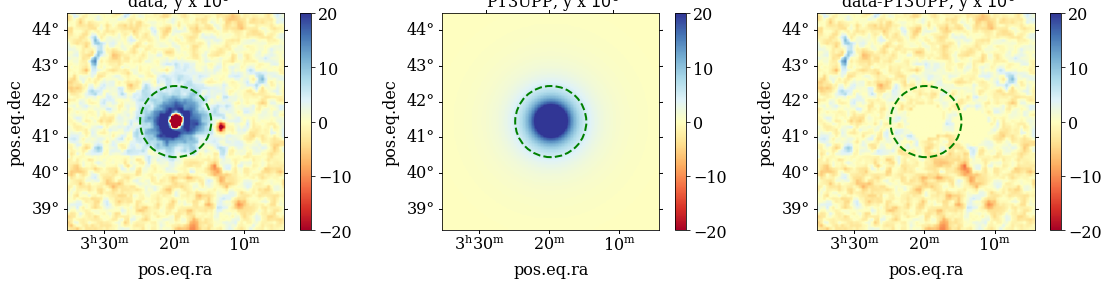

In [7]:
rad = cluster.theta500.to_value('deg')

fig = plt.figure(0, figsize=(18, 4))
ax = plt.subplot(131, projection=WCS(header))
plt.imshow(1e6*ymap_data, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(' data, y x $10^6$')
ax = plt.subplot(132, projection=WCS(header))
plt.imshow(1e6*ymap_p13upp, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(' P13UPP, y x $10^6$')
ax = plt.subplot(133, projection=WCS(header))
plt.imshow(1e6*(ymap_data-ymap_p13upp)*mask, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(' data-P13UPP, y x $10^6$')
plt.savefig(cluster.output_dir+'/ResultsTh_UPP_residual')

# MCMC fit

In [8]:
#----- Defines log likelihood
def lnlike(params, cluster, data, err) :
    cond1 = params[0]>=0 and params[1]>=0 and params[2]>=0 and params[3]>=0 and params[4]>=0 and params[5]>=0
    if cond1:
        mod = model(cluster, params)
        chi2 = ((data - mod)**2) / (err**2)
        return -0.5*np.nansum(chi2)
    else:
        return -np.inf

In [9]:
#----- Defines model
def model(cluster, params, no_ps=False, no_zl=False):
    P_0      = params[0]
    r_p      = params[1]
    a        = params[2]
    b        = params[3]
    c        = params[4]
    srcflux  = params[5]
    srcwidth = 7.0 # From radio images, it is nearly resolved!
    zl       = params[6]

    # SZ contribution
    cluster.pressure_gas_model['P_0'] = P_0*u.keV/u.cm**3
    cluster.pressure_gas_model['r_p'] = r_p*u.kpc
    cluster.pressure_gas_model['a']   = a
    cluster.pressure_gas_model['b']   = b
    cluster.pressure_gas_model['c']   = c
    ymod = (cluster.get_sz_map(Compton_only=True)).value

    # Point source contribution
    ramap, decmap = map_tools.get_radec_map(header)
    distance = map_tools.greatcircle(ramap, decmap, 
                                     cluster.coord.ra.to_value('deg'), cluster.coord.dec.to_value('deg'))
    psmod = srcflux*np.exp(-distance**2/(2.0*(srcwidth/60*FWHM2sigma)**2))
    
    # Special case
    if no_ps:
        psmod = psmod*0
    if no_zl:
        zl = zl*0.0
    
    return ndimage.gaussian_filter(ymod-psmod+zl, sigma=FWHM2sigma*(FWHM_planck/map_reso).to_value(''), order=0)

In [10]:
#----- Define the MCMC
if mask_source:
    par0 = np.array([0.0031501902215784385, 
                     995.9758757790506, 
                     2.691626440902112, 
                     3.9924117580078224, 
                     0.40701732901885296, 
                     0.009231085359942472, 
                     -7.930953936650688e-07])
else:
    par0 = np.array([0.0018412107645660722, 
                     1023.3577820701736, 
                     4.607515672418834, 
                     3.6087586040158373, 
                     0.7556834669070442, 
                     0.0009644245413367812, 
                     -7.898055243376427e-07])

param_name = ['P0', 'r_p', 'a','b','c','srcflux', 'Z_l']
ndim, nwalkers, nsteps, burnin = len(par0), 20, 500, 50
pos = [par0 + par0*1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [11]:
#----- Define MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=[cluster, ymap_data, ymap_err], pool=Pool(cpu_count()))

#----- Restart from where it is or reset
sampler.reset()
        
#----- Run
res = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 500/500 [01:34<00:00,  5.26it/s]


In [12]:
#----- Burn in
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

In [13]:
#----- Get the best fit parameters
wbest = (lnL_chains == np.amax(lnL_chains))
param_best = []
for i in range(ndim):
    param_best.append(((param_chains[:,:,i])[wbest])[0])

In [14]:
#----- MC parameters
param_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1],param_chains.shape[2])
Nsample = len(param_flat[:,0])-1
param_MC = np.zeros((Nmc, ndim))
for i in range(Nmc):
    param_MC[i,:] = param_flat[np.random.randint(0, high=Nsample), :] # randomly taken from chains

# Result

### Parameters

In [15]:
print(param_best)

[0.0030532010660539255, 991.4960053043638, 2.596688362658096, 4.1721375156447, 0.5419367731961833, 0.014799274004880764, -6.967270896424618e-07]


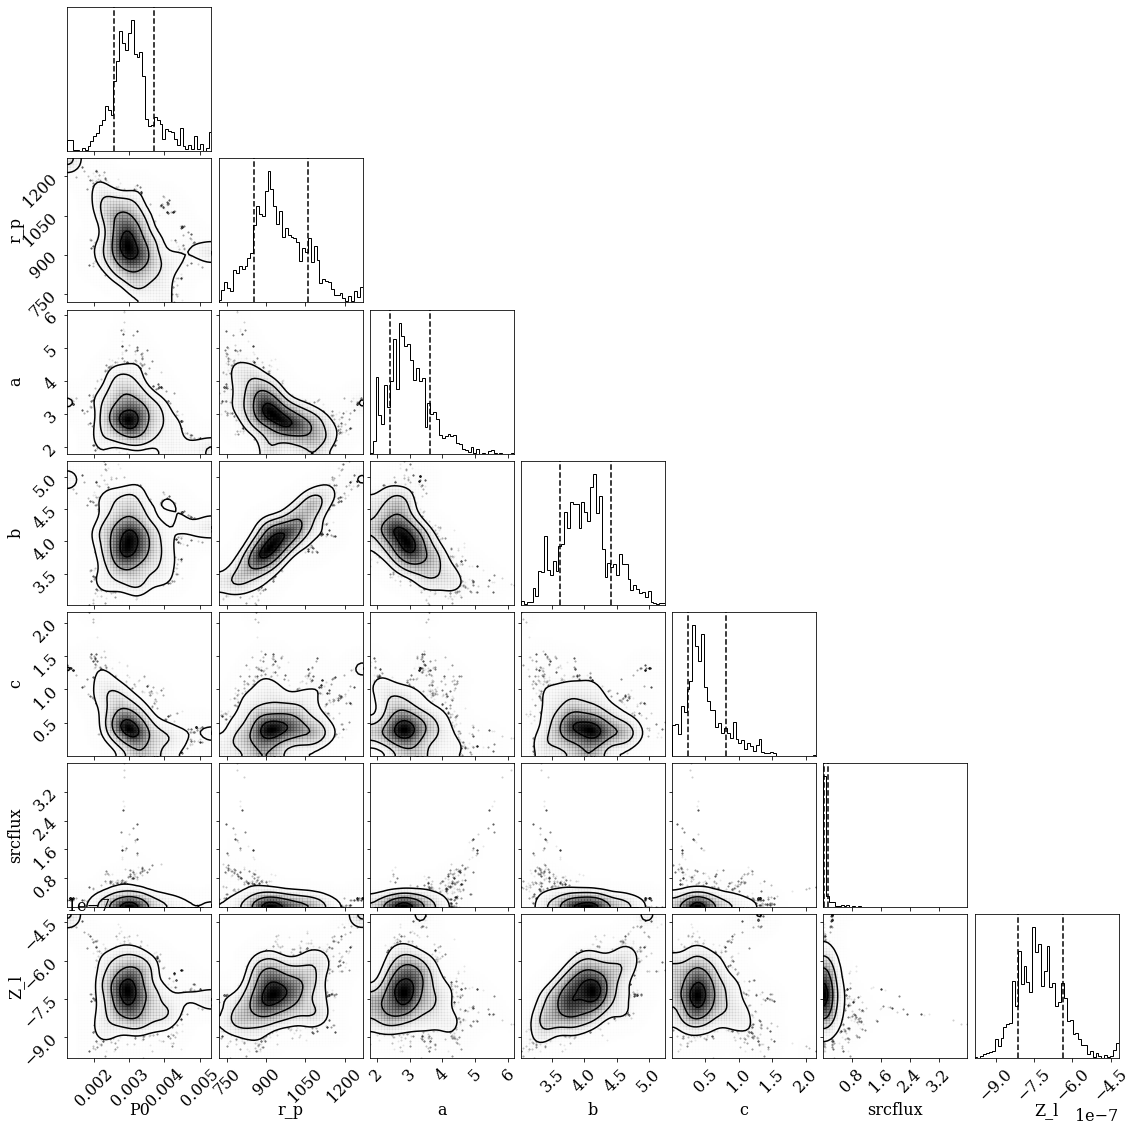

In [16]:
#----- Parameter space
par_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1], param_chains.shape[2])
fig = corner.corner(par_flat, bins=50, color='k', smooth=3, labels=param_name, quantiles=(0.16, 0.84))
plt.savefig(cluster.output_dir+'/ResultsTh_corner'+'_mask'+str(mask_source))

### Residual maps

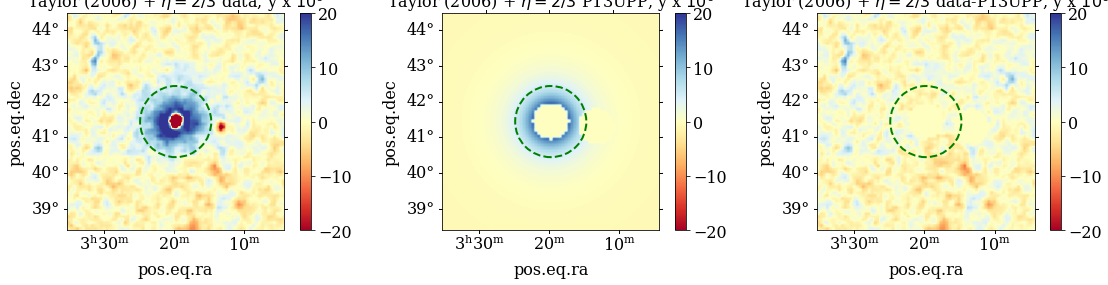

In [17]:
ymap_best = model(cluster, param_best)
ymap_best_nops = model(cluster, param_best, no_ps=True)

fig = plt.figure(0, figsize=(18, 4))
ax = plt.subplot(131, projection=WCS(header))
plt.imshow(1e6*ndimage.gaussian_filter(ymap_data, sigma=FWHM2sigma*(2.0*u.arcmin/map_reso).to_value(''), order=0), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' data, y x $10^6$')

ax = plt.subplot(132, projection=WCS(header))
plt.imshow(1e6*mask*ndimage.gaussian_filter(ymap_best, sigma=FWHM2sigma*(2.0*u.arcmin/map_reso).to_value(''), order=0), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' P13UPP, y x $10^6$')

ax = plt.subplot(133, projection=WCS(header))
plt.imshow(1e6*mask*ndimage.gaussian_filter(ymap_data-ymap_best, sigma=FWHM2sigma*(2.0*u.arcmin/map_reso).to_value(''), order=0), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' data-P13UPP, y x $10^6$')
plt.savefig(cluster.output_dir+'/ResultsTh_residual'+'_mask'+str(mask_source))

### Residual profiles

In [18]:
yprof_rad, yprof_data, yprof_err = map_tools.radial_profile_sb(ymap_data-param_best[6], 
                                                               (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                               stddev=ymap_err,
                                                               header=header,
                                                               binsize=yprof_reso.to_value('deg'))

if mask_source:
    yprof_rad, yprof_mod, bid = map_tools.radial_profile_sb(ymap_best_nops-param_best[6], 
                                                            (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                            stddev=ymap_best*0+1,
                                                            header=header,
                                                            binsize=yprof_reso.to_value('deg'))
else:
    yprof_rad, yprof_mod, bid = map_tools.radial_profile_sb(ymap_best-param_best[6], 
                                                            (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                            stddev=ymap_best*0+1,
                                                            header=header,
                                                            binsize=yprof_reso.to_value('deg'))

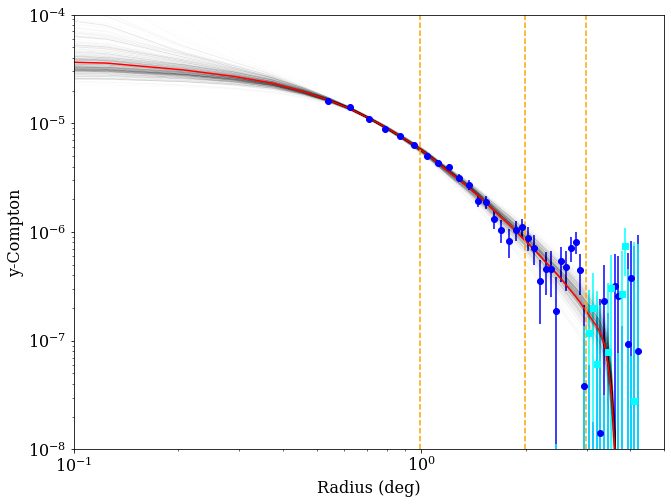

In [19]:
plt.figure(figsize=(10,8))
plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='blue')
plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='s', linestyle='', color='cyan')
for imc in range(Nmc):
    if mask_source:
        ymap_mc = model(cluster, param_MC[imc,:], no_ps=True, no_zl=True)
    else:
        ymap_mc = model(cluster, param_MC[imc,:], no_ps=False, no_zl=True)        
    yprof_rad, yprof_mc, bid = map_tools.radial_profile_sb(ymap_mc, 
                                                           (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                           stddev=ymap_best*0+1,
                                                           header=header,
                                                           binsize=yprof_reso.to_value('deg'))
    plt.plot(yprof_rad, yprof_mc, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
    plt.plot(yprof_rad, -yprof_mc, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
plt.plot(yprof_rad, yprof_mod, linestyle='-', color='red')
plt.plot(yprof_rad, -yprof_mod, linestyle='-', color='red')
plt.plot([1*cluster.theta500.to_value('deg'),1*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.plot([2*cluster.theta500.to_value('deg'),2*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.plot([3*cluster.theta500.to_value('deg'),3*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.ylim(1e-8, 1e-4)
plt.xlim(1e-1, 5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('y-Compton')
plt.savefig(cluster.output_dir+'/ResultsTh_compton'+'_mask'+str(mask_source))

### Pressure profile

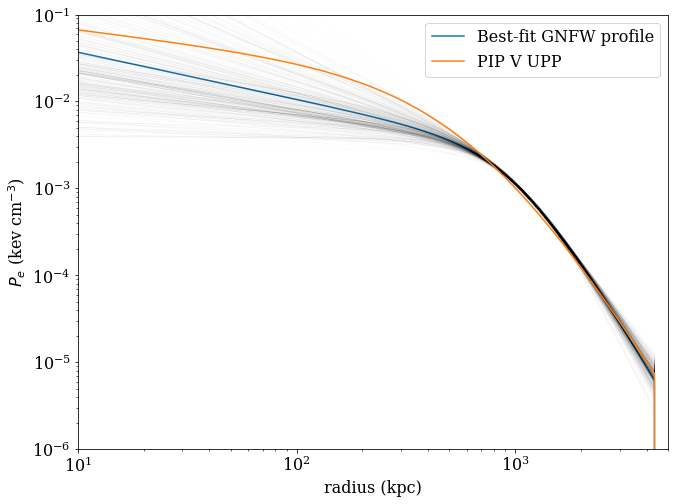

In [20]:
# How to derive the Pressure and Compton parameter profile
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_best[0]*u.keV/u.cm**3, 
                              'r_p':param_best[1]*u.kpc,
                              'a':param_best[2], 
                              'b':param_best[3], 
                              'c':param_best[4]}
plt.figure(figsize=(10,8))
r, p_r = cluster.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Best-fit GNFW profile')
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    r, p_r = cluster.get_pressure_gas_profile()
    plt.loglog(r, p_r, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
cluster.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = cluster.get_pressure_gas_profile()
plt.loglog(r, p_r, label='PIP V UPP')
plt.xlabel('radius (kpc)')
plt.ylabel('$P_e$ (kev cm$^{-3}$)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(1e-6,1e-1)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_pressure'+'_mask'+str(mask_source))

### Uth500

In [21]:
U_th500 = []
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    U_th500.append(cluster.get_thermal_energy_profile(radius=cluster.R500)[1][0].to_value('erg'))

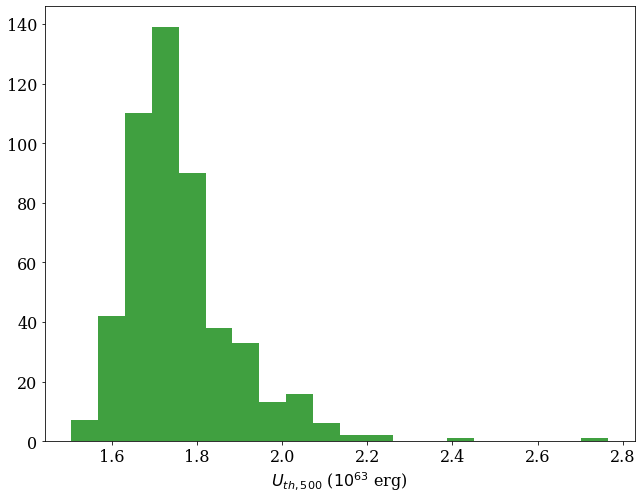

In [22]:
plt.figure(figsize=(10,8))
n,b,p = plt.hist(np.array(U_th500)/1e63, 20, facecolor='green', alpha=0.75)
plt.xlabel('$U_{th,500}$ ($10^{63}$ erg)')
#plt.xlim(1.82,1.94)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_uth500'+'_mask'+str(mask_source))

In [23]:
cluster.set_pressure_gas_gNFW_param('P13UPP')
print('P13 UPP: ',cluster.get_thermal_energy_profile(radius=cluster.R500)[1][0])

ctmp = copy.deepcopy(cluster)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
print('Urban calib. P13 UPP: ',ctmp.get_thermal_energy_profile(radius=ctmp.R500)[1][0])

P13 UPP:  1.9912749147619087e+63 erg
Urban calib. P13 UPP:  1.9912749147619087e+63 erg


### Implication for the temperature and other thermodynamic quantities

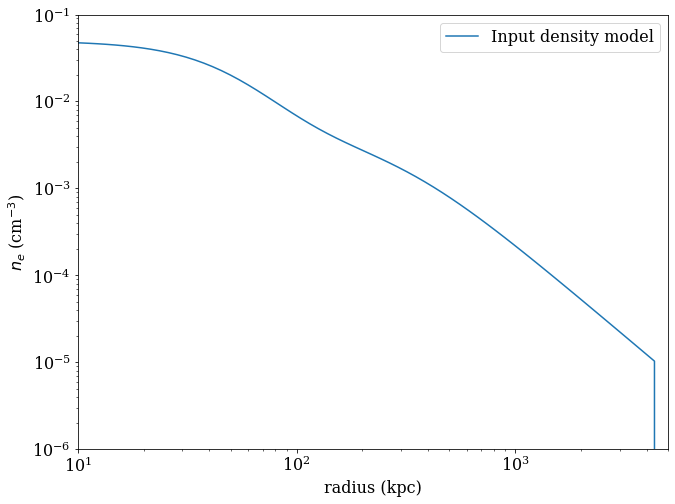

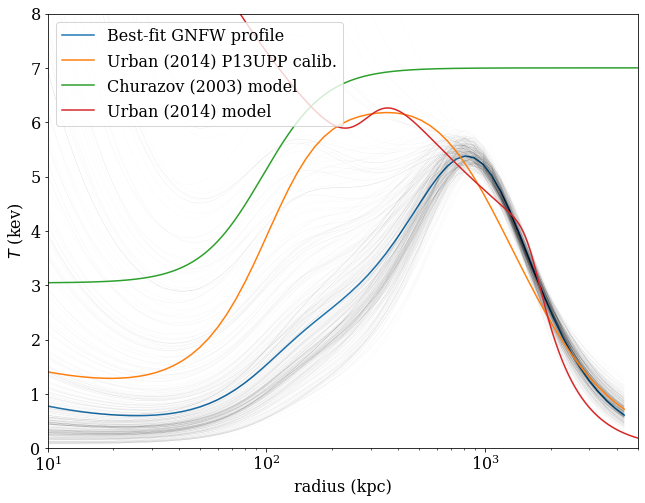

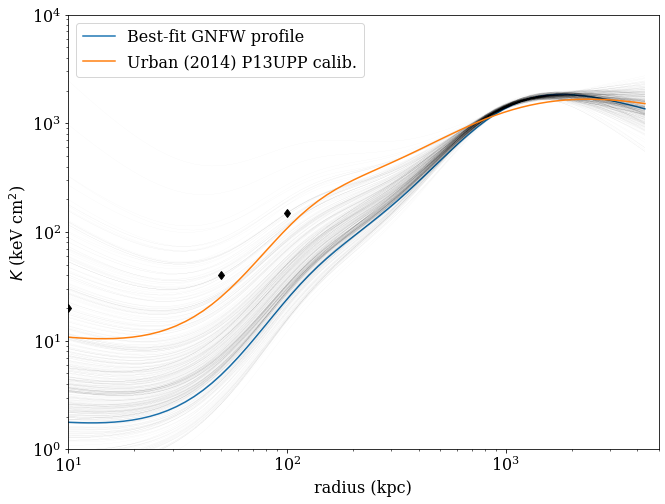

In [24]:
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_best[0]*u.keV/u.cm**3, 
                              'r_p':param_best[1]*u.kpc,
                              'a':param_best[2], 
                              'b':param_best[3], 
                              'c':param_best[4]}

plt.figure(figsize=(10,8))
r, n_r = cluster.get_density_gas_profile()
plt.loglog(r, n_r, label='Input density model')
plt.xlabel('radius (kpc)')
plt.ylabel('$n_e$ (cm$^{-3}$)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(0.000001,0.1)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_density'+'_mask'+str(mask_source))

plt.figure(figsize=(10,8))
r, t_r = cluster.get_temperature_gas_profile()
plt.plot(r, t_r, label='Best-fit GNFW profile')
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    r, t_r = cluster.get_temperature_gas_profile()
    plt.plot(r, t_r, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
ctmp = copy.deepcopy(cluster)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
r, t_r = ctmp.get_temperature_gas_profile()
plt.plot(r, t_r, label='Urban (2014) P13UPP calib.')
radius = np.logspace(1,4,1000)*u.kpc
Te_Chu03 = 7.0*(1+(radius.to_value('kpc')/(100.0*0.73))**3)/(2.3+(radius.to_value('kpc')/(100.0*0.73))**3)*u.keV
Te_Urb14 = 4.06*u.keV*((radius.to_value('kpc')/294)**6.72+0.72)/(1+(radius.to_value('kpc')/294)**6.72)*((radius.to_value('Mpc')/1.6)**-0.33)/(1+(radius.to_value('Mpc')/1.6)**16.24)**(2.36/16.24)
plt.plot(radius,Te_Chu03, label='Churazov (2003) model')
plt.plot(radius,Te_Urb14, label='Urban (2014) model')
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('$T$ (kev)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(0,8)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_temperature'+'_mask'+str(mask_source))

plt.figure(figsize=(10,8))
r, k_r = cluster.get_entropy_gas_profile()
plt.loglog(r, k_r, label='Best-fit GNFW profile')
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    r, k_r = cluster.get_entropy_gas_profile()
    plt.loglog(r, k_r, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
ctmp = copy.deepcopy(cluster)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
r, k_r = ctmp.get_entropy_gas_profile()
plt.loglog(r, k_r, label='Urban (2014) P13UPP calib.')
plt.loglog([10,50,100], [20,40,150], marker='d', linestyle='', color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('$K$ (keV cm$^{2}$)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(1,1e4)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_entropy'+'_mask'+str(mask_source))